# CLASIFICAR ggF y VBF CON MACHINE LEARNING

## PAQUETES

In [1]:
# dataframes 
import numpy as np
# import pandas as pd
import polars as pd

# cargar archivos
import uproot
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import sys
import yaml

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# funcion de xgboost que clasifica
from xgboost import XGBClassifier

# graficar el arbol de desiciones del modelo, rcparams es para que se vea HD
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# medir que tan bueno es el modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# encontrar mejor modelo (validacion)
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score

# ver la prueba de ks
from scipy.stats import kstest

# funciones creadas
from lectura import *
from formulas import *
from cortes import *
from graficar import *
from machine_learning import *
from metricas import *

# para recargar los modulos mientras los voy debugeando
%load_ext autoreload
%autoreload 2

# LECTURA DE DATOS

In [2]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# cargar archivo yaml
path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('parametros_ml.yaml')      #Parámetros del calo

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [3]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)
df_all

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:03,  2.28it/s]

samples/VBF/frvz_vbf_500757


 25%|██▌       | 2/8 [00:00<00:02,  2.27it/s]

samples/VBF/frvz_vbf_500758


 38%|███▊      | 3/8 [00:01<00:02,  2.26it/s]

samples/VBF/frvz_vbf_500759


 50%|█████     | 4/8 [00:01<00:01,  2.42it/s]

samples/VBF/frvz_vbf_500760


 62%|██████▎   | 5/8 [00:02<00:01,  2.26it/s]

samples/VBF/frvz_vbf_500761


 75%|███████▌  | 6/8 [00:02<00:00,  2.27it/s]

samples/VBF/frvz_vbf_500762


 88%|████████▊ | 7/8 [00:03<00:00,  2.30it/s]

samples/VBF/frvz_vbf_500763


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


samples/VBF/frvz_vbf_500764


100%|██████████| 9/9 [00:16<00:00,  1.78s/it]


njet30          mjj      detajj  \
origin df_name                                                        
VBF    samples/VBF/frvz_vbf_500757       2  1316.194214    5.130603   
       samples/VBF/frvz_vbf_500757       7  2287.880371    7.156201   
       samples/VBF/frvz_vbf_500757       2  1568.506470    6.255918   
       samples/VBF/frvz_vbf_500757       4   471.740875    1.960242   
       samples/VBF/frvz_vbf_500757       8  1150.059692    4.557185   
...                                    ...          ...         ...   
ggF    samples/ggF/frvz_ggf_508893       1    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       3   240.689178    1.942230   
       samples/ggF/frvz_ggf_508893       2   143.422470    2.548514   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   

                                        dphijj         MET  scale1fb  \
origin df_name                                                         
VBF    samples/VBF/frvz_vbf_500757    1.032967  177.043106  0.000486   
       samples/VBF/frvz_vbf_500757   -2.580441  101.195091  0.000502   
       samples/VBF/frvz_vbf_500757   -1.375577  130.909744  0.000429   
       samples/VBF/frvz_vbf_500757    2.980181  491.291687  0.000531   
       samples/VBF/frvz_vbf_500757    2.197970  115.439743  0.000014   
...                                        ...         ...       ...   
ggF    samples/ggF/frvz_ggf_508893 -999.000000   40.554482  0.028479   
       samples/ggF/frvz_ggf_508893    0.768057   76.802452  0.029882   
       samples/ggF/frvz_ggf_508893    2.000947   26.644657  0.029517   
       samples/ggF/frvz_ggf_508893 -999.000000   10.709071  0.029929   
       samples/ggF/frvz_ggf_508893 -999.000000   10.808948  0.030318   

                                      intLumi        jet1_pt    jet1_eta  \
origin df_name                                                             
VBF    samples/VBF/frvz_vbf_500757  44.299999  104969.406250   -3.187121   
       samples/VBF/frvz_vbf_500757  44.299999   72039.820312    3.637084   
       samples/VBF/frvz_vbf_500757  44.299999  120273.304688   -2.382490   
       samples/VBF/frvz_vbf_500757  44.299999  178915.984375    1.259632   
       samples/VBF/frvz_vbf_500757  44.299999  189834.156250   -2.913896   
...                                       ...            ...         ...   
ggF    samples/ggF/frvz_ggf_508893  58.450001   33552.746094    0.995871   
       samples/ggF/frvz_ggf_508893  58.450001  125251.289062   -2.288580   
       samples/ggF/frvz_ggf_508893  58.450001   40318.128906   -3.305732   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   

                                      jet1_phi        jet1_e        jet2_pt  \
origin df_name                                                                
VBF    samples/VBF/frvz_vbf_500757   -0.087903  1.273288e+06   98169.875000   
       samples/VBF/frvz_vbf_500757    0.712928  1.369027e+06   56599.265625   
       samples/VBF/frvz_vbf_500757   -2.404870  6.569827e+05   39280.699219   
       samples/VBF/frvz_vbf_500757   -2.167910  3.411552e+05  133583.312500   
       samples/VBF/frvz_vbf_500757   -1.059290  1.754382e+06   72083.078125   
...                                        ...           ...            ...   
ggF    samples/ggF/frvz_ggf_508893   -2.499207  5.242589e+04    -999.000000   
       samples/ggF/frvz_ggf_508893    1.335905  6.239932e+05   79405.820312   
       samples/ggF/frvz_ggf_508893    0.382778  5.504859e+05   36411.175781   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   

                                      jet2_eta    jet2_phi        jet2_e  
origin df_name                                                            
VBF    s

# CORTES Y PREPROCESADO

In [4]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_ml = df_all_cut
df_ml = df_ml.droplevel('df_name')
df_ml = df_ml.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_ml = df_ml.reset_index(level='origin')
df_ml = pd.get_dummies(df_ml, columns=['origin'], dtype=int)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml.drop(['origin_VBF', 'origin_ggF'], axis=1) 
df_y = df_ml[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3)#, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5)

df_ml

Numero eventos antes: 4628576
Corte: njet30 entre [1, inf]
Numero eventos despues: 2013265 



,mjj,detajj,dphijj,MET,jet1_pt,jet1_eta,jet1_phi,jet1_e,jet2_pt,jet2_eta,jet2_phi,jet2_e,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,104969.406250,-3.187121,-0.087903,1.273288e+06,98169.875000,1.943482,-1.120870,3.498132e+05,1,0
1,2287.880371,7.156201,-2.580441,101.195091,72039.820312,3.637084,0.712928,1.369027e+06,56599.265625,-3.519117,-2.989815,9.561007e+05,1,0
2,1568.506470,6.255918,-1.375577,130.909744,120273.304688,-2.382490,-2.404870,6.569827e+05,39280.699219,3.873428,-1.029293,9.452691e+05,1,0
3,471.740875,1.960242,2.980181,491.291687,178915.984375,1.259632,-2.167910,3.411552e+05,133583.312500,3.219874,1.135094,1.674184e+06,1,0
4,1150.059692,4.557185,2.197970,115.439743,189834.156250,-2.913896,-1.059290,1.754382e+06,72083.078125,1.643289,3.025926,1.938794e+05,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012571,86.820213,0.779352,3.074377,36.471001,45681.097656,3.302509,-0.662832,6.216837e+05,35162.062500,2.523157,2.545976,2.206442e+05,0,1
2012572,69.304848,0.293507,-2.302855,5.845552,40501.546875,1.277558,-3.141293,7.845353e+04,33459.644531,0.984051,-0.838438,5.148936e+04,0,1
2012573,506.555878,2.252506,-3.031298,27.214394,152246.031250,1.397108,1.148800,3.269545e+05,144588.734375,-0.855398,-2.103087,2.015532e+05,0,1
2012574,240.689178,1.942230,0.768057,76.802452,125251.289062,-2.288580,1.335905,6.239932e+05,79405.820312,-0.346350,0.567848,8.514269e+04,0,1


# ANALISIS PREVIO

In [5]:
# veamos si hago bien el corte de njet30
# sns.histplot(data = df_all["njet30"], bins=30)
# sí se borraban cosas, habian datos originalmente con njet30 con valores 0 o 1, la cosa que me decía el número de entradas antes y después no estaba actualizado para el código actual

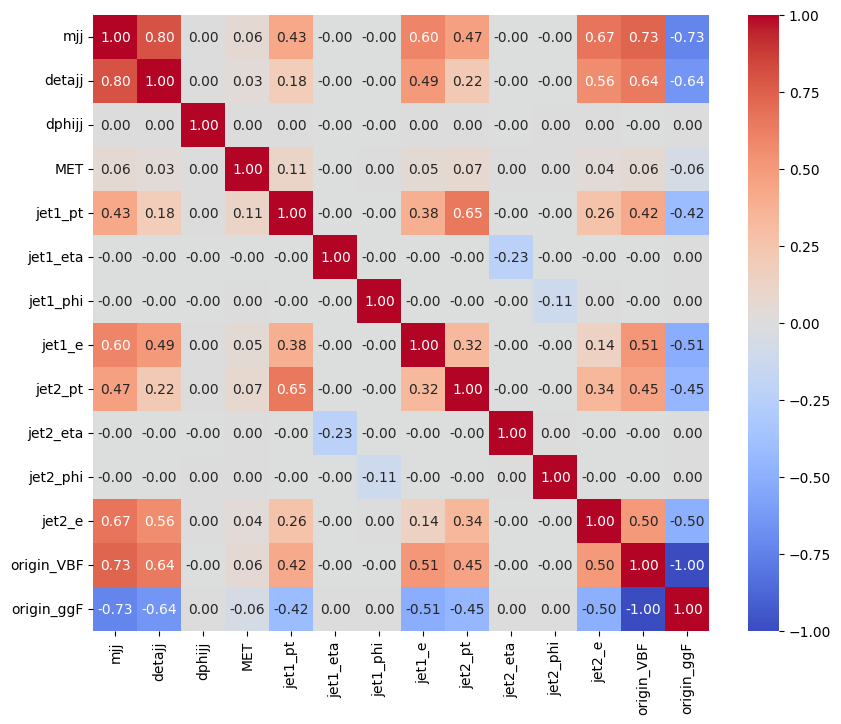

In [6]:
########################################################
##################### CORRELACION ######################
########################################################

plot_correlacion(df_ml)

In [7]:
# ver las correlaciones en orden de importancia con origin vbf
correlaciones(df_ml, "origin_VBF")

origin_VBF    1.000000
mjj           0.734283
detajj        0.641705
jet1_e        0.513482
jet2_e        0.498435
jet2_pt       0.446498
jet1_pt       0.420065
MET           0.061332
dphijj       -0.000212
jet1_phi     -0.000397
jet2_eta     -0.001333
jet1_eta     -0.001530
jet2_phi     -0.002847
origin_ggF   -1.000000
Name: origin_VBF, dtype: float64

notemos que podría borrar las variables phi, y solo quedarme con las eta (o viceversa)

Ademas borro jet2_phi porque se parece mucho a dphijj

Ademas borro MET porque no aporta en nada

# PREPROCESADO MEJORADO TRAS ANALISIS

In [8]:
df_ml['origin_ggF']
df_ml2 = df_ml.drop(['jet2_eta', 'jet1_eta', 'jet2_phi', 'MET', 'origin_ggF', 'dphijj', 'jet1_phi'], axis=1)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml2.drop(['origin_VBF'], axis=1) 
df_y = df_ml2[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3, random_state=228)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5, random_state=228)
X_test, y_test = X_metrico, y_metrico 

df_ml2

,mjj,detajj,jet1_pt,jet1_e,jet2_pt,jet2_e,origin_VBF
0,1316.194214,5.130603,104969.406250,1.273288e+06,98169.875000,3.498132e+05,1
1,2287.880371,7.156201,72039.820312,1.369027e+06,56599.265625,9.561007e+05,1
2,1568.506470,6.255918,120273.304688,6.569827e+05,39280.699219,9.452691e+05,1
3,471.740875,1.960242,178915.984375,3.411552e+05,133583.312500,1.674184e+06,1
4,1150.059692,4.557185,189834.156250,1.754382e+06,72083.078125,1.938794e+05,1
...,...,...,...,...,...,...,...
2012571,86.820213,0.779352,45681.097656,6.216837e+05,35162.062500,2.206442e+05,0
2012572,69.304848,0.293507,40501.546875,7.845353e+04,33459.644531,5.148936e+04,0
2012573,506.555878,2.252506,152246.031250,3.269545e+05,144588.734375,2.015532e+05,0
2012574,240.689178,1.942230,125251.289062,6.239932e+05,79405.820312,8.514269e+04,0


nota: no cambió en nada el resultado, no afectó las cosas que borré

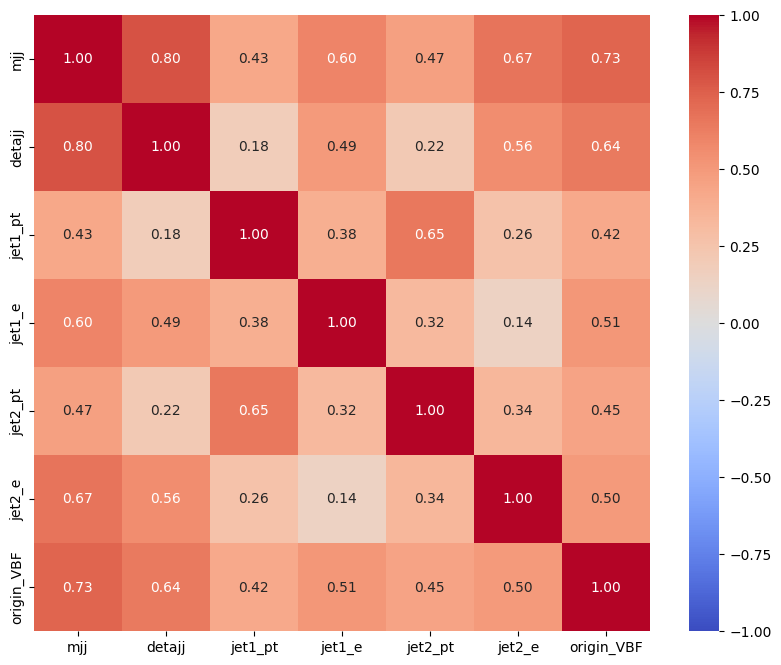

In [9]:
plot_correlacion(df_ml2)

In [10]:
correlaciones(df_ml2, "origin_VBF")

origin_VBF    1.000000
mjj           0.734283
detajj        0.641705
jet1_e        0.513482
jet2_e        0.498435
jet2_pt       0.446498
jet1_pt       0.420065
Name: origin_VBF, dtype: float64

In [11]:
prueba_ks(df_ml2, "mjj", "norm")

Se rechaza la hipótesis nula, p vale: 0.0. Los datos no siguen una distribución norm.


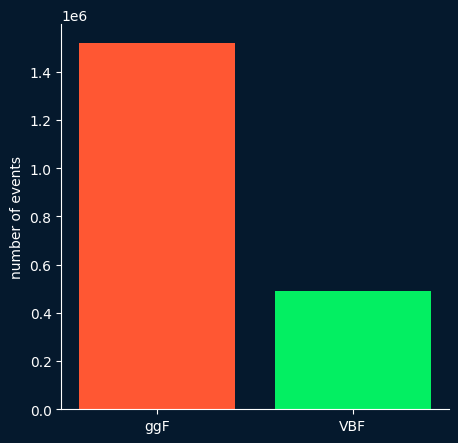

1521532
491044
0.756012195315854
0.24398780468414608


In [12]:
n_ggF = df_ml2[df_ml2["origin_VBF"]==0].count()[0]
n_VBF = df_ml2[df_ml2["origin_VBF"]==1].count()[0]

# {"ggF": "#FF5733", "VBF": "#03ef62"}
# Plotting the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=[5, 5])
plt.bar("ggF", n_ggF, label='Value 1', color='#FF5733', edgecolor='none')
plt.bar("VBF", n_VBF, label='Value 2', color='#03ef62', edgecolor='none')

# Adding labels and title
# plt.xlabel('', color='white')
plt.ylabel('number of events', color='white')
# plt.title('Horizontal Stacked Bar Plot', color='white')

# Adding legend
# plt.legend()

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y

# Display the plot
plt.show()

ggf_percentage = n_ggF/(n_ggF+n_VBF)
vbf_percentage = n_VBF/(n_ggF+n_VBF)

print(n_ggF)
print(n_VBF)
print(ggf_percentage)
print(vbf_percentage)

In [13]:
from scipy.stats import ks_2samp

ks_2samp(y_train["origin_VBF"], y_test["origin_VBF"])

KstestResult(statistic=0.0001378209687372678, pvalue=1.0, statistic_location=0, statistic_sign=-1)

In [14]:
print(ks_2samp(np.zeros(1000), np.zeros(1000)))
print(ks_2samp(np.ones(1000), np.zeros(1000)))

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.0, statistic_sign=1)
KstestResult(statistic=1.0, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)


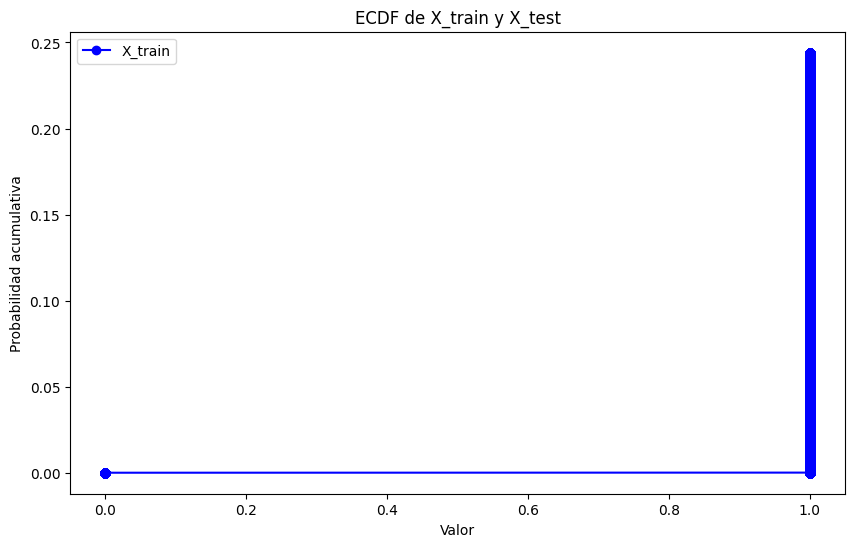

[0.         0.         0.         ... 0.24402773 0.24402844 0.24402915]


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que X_train y X_test son tus dos muestras
ecdf_train = np.cumsum(np.sort(y_train["origin_VBF"])) / len(y_train["origin_VBF"])
ecdf_test = np.cumsum(np.sort(y_test["origin_VBF"])) / len(y_test["origin_VBF"])

plt.figure(figsize=(10, 6))

# Gráfico ECDF para X_train
plt.plot(np.sort(y_train["origin_VBF"]), ecdf_train, label='X_train', marker='o', linestyle='-', color='blue')

# Gráfico ECDF para X_test
# plt.plot(np.sort(y_test["origin_VBF"]), ecdf_test, label='X_test', marker='o', linestyle='-', color='orange')

plt.title('ECDF de X_train y X_test')
plt.xlabel('Valor')
plt.ylabel('Probabilidad acumulativa')
plt.legend()
plt.show()
print(ecdf_train)

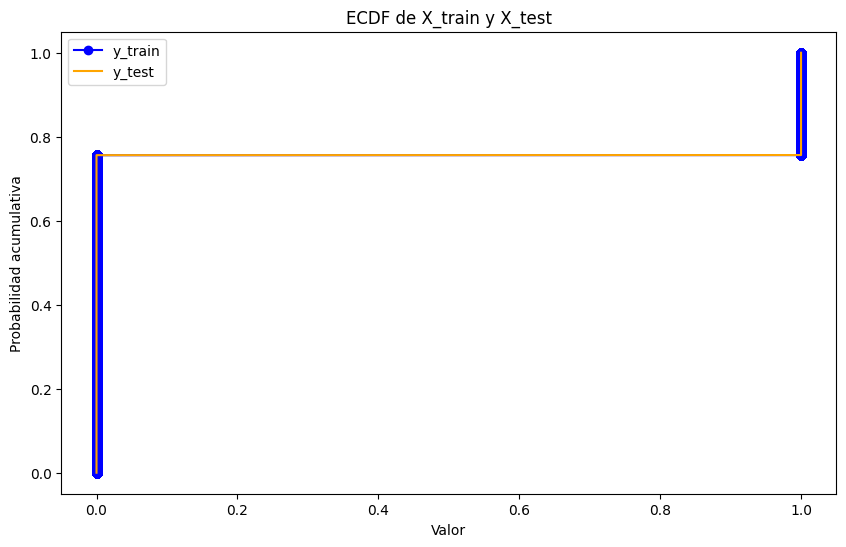

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que X_train y X_test son tus dos muestras
y_train_sorted = np.sort(y_train["origin_VBF"])
y_test_sorted = np.sort(y_test["origin_VBF"])

ecdf_train = np.arange(1, len(y_train_sorted) + 1) / len(y_train_sorted)
ecdf_test = np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted)

plt.figure(figsize=(10, 6))

# Gráfico ECDF para X_train
plt.plot(y_train_sorted, ecdf_train, label='y_train', marker='o', linestyle='-', color='blue')

# Gráfico ECDF para X_test
plt.plot(y_test_sorted, ecdf_test, label='y_test', linestyle='-', color='orange')

plt.title('ECDF de X_train y X_test')
plt.xlabel('Valor')
plt.ylabel('Probabilidad acumulativa')
plt.legend()
plt.show()

# MACHINE LEARNING

In [17]:
########################################################
#################### CLASIFICACION #####################
########################################################
params = {"learning_rate":0.1,
          "max_depth":7, # puse eso porque hay 7 variables
          "n_estimators":100,
          "eval_metric":["logloss", "auc"],
          "verbosity":2,
          "objective":"binary:logistic",
          "gamma":0.1, # esto es para evitar el sobreajuste, limita la creacion de ramas
        #   "device":"cuda"
          }

# params = { "n_estimators": 800,
#             "max_depth": 12,
#             "learning_rate": 0.5,
#             "gamma": 0.6,
#             "min_child_weight": 1,
#             "reg_lambda": 100,
#           #  "scale_pos_weight": scale_pos_weight,
#             "eval_metric": ["logloss", "auc"],
#             # "early_stopping_rounds": 5,
#             "objective":"binary:logistic",
#             "verbosity": 1
#             }

modelo = XGBRegressor(**params)
# modelo = XGBClassifier(**params)
# modelo.fit(X_train, y_train, eval_set=[(X_val, y_val)])
modelo = do_classification(X_train, y_train, params)

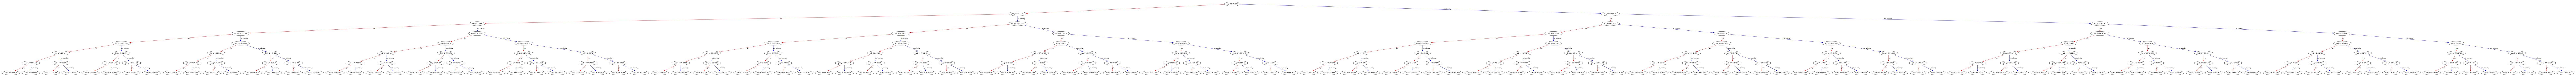

In [18]:
grafico_decisiones(modelo)

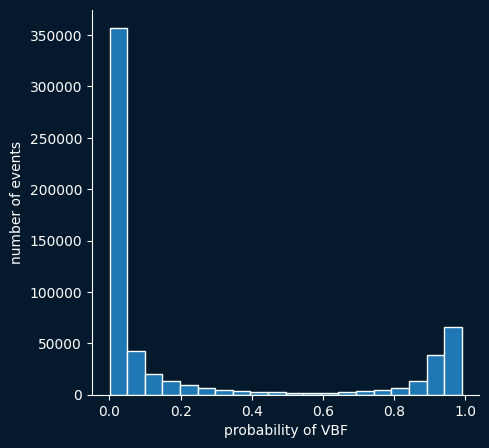

In [19]:
y_pred = modelo.predict(X_test)
fig, ax = plt.subplots(figsize=[5, 5])
plt.hist(y_pred, bins = 20, edgecolor='white') # antes usaba sns
plt.ylabel('number of events', color='white')
plt.xlabel('probability of VBF', color='white')

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y
    
plt.show()

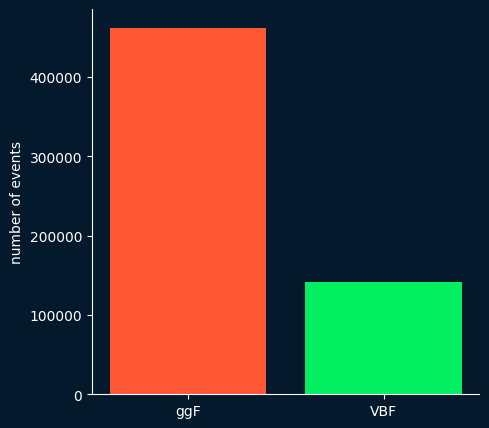

462354
141419
0.7657745543440995
0.23422544565590048


In [30]:
y_pred = modelo.predict(X_test)
n_ggF = y_pred[y_pred<0.5].shape[0]
n_VBF = y_pred[y_pred>0.5].shape[0]

# {"ggF": "#FF5733", "VBF": "#03ef62"}
# Plotting the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=[5, 5])
plt.bar("ggF", n_ggF, label='Value 1', color='#FF5733', edgecolor='none')
plt.bar("VBF", n_VBF, label='Value 2', color='#03ef62', edgecolor='none')

# Adding labels and title
# plt.xlabel('', color='white')
plt.ylabel('number of events', color='white')
# plt.title('Horizontal Stacked Bar Plot', color='white')

# Adding legend
# plt.legend()

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y

# Display the plot
plt.show()

ggf_percentage = n_ggF/(n_ggF+n_VBF)
vbf_percentage = n_VBF/(n_ggF+n_VBF)

print(n_ggF)
print(n_VBF)
print(ggf_percentage)
print(vbf_percentage)

In [21]:
from scipy.stats import ks_2samp

ks_2samp(y_test["origin_VBF"], y_pred)

KstestResult(statistic=0.756108669980274, pvalue=0.0, statistic_location=0.0, statistic_sign=1)

In [22]:
from scipy.stats import ks_2samp

ks_2samp(y_test["origin_VBF"], y_pred>0.5)
# ks_2samp(y_test["origin_VBF"], y_test["origin_VBF"])

KstestResult(statistic=0.009665884363825428, pvalue=6.297753301976572e-25, statistic_location=0, statistic_sign=-1)

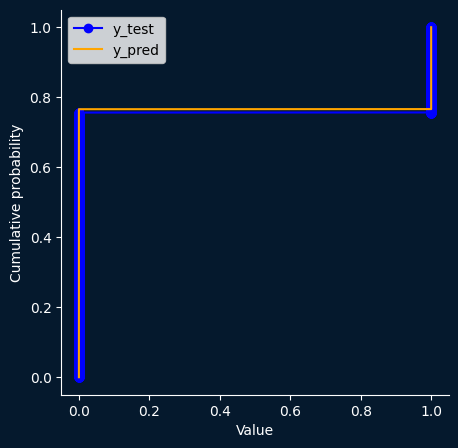

In [23]:
import numpy as np
import matplotlib.pyplot as plt

y_test_sorted = np.sort(y_test["origin_VBF"])
y_pred_sorted = np.sort(y_pred>0.5)
# y_pred_sorted = np.sort(y_pred)

ecdf_test = np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted)
ecdf_pred = np.arange(1, len(y_pred_sorted) + 1) / len(y_pred_sorted)

fig, ax = plt.subplots(figsize=[5, 5])

# Gráfico ECDF para X_train
plt.plot(y_test_sorted, ecdf_test, label='y_test', marker='o', linestyle='-', color='blue')

# Gráfico ECDF para X_test
plt.plot(y_pred_sorted, ecdf_pred, label='y_pred', linestyle='-', color='orange')

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


# plt.title('CDF')
plt.xlabel('Value', color="white")
plt.ylabel('Cumulative probability', color="white")
plt.legend()
plt.show()

KstestResult(statistic=0.0006399327157681212, pvalue=0.9951264578510437, statistic_location=0.85378826, statistic_sign=1)


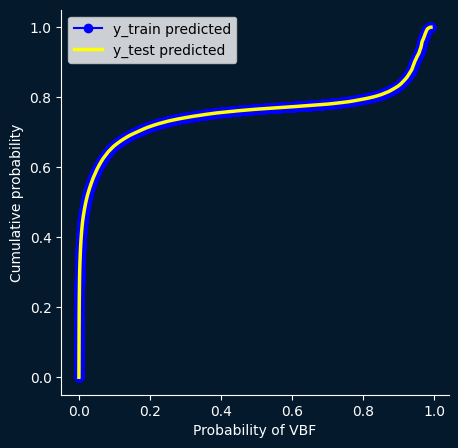

In [28]:
y_pred_test = modelo.predict(X_test)
y_pred_train = modelo.predict(X_train)

print(ks_2samp(y_pred_train, y_pred_test))

y_train_sorted = np.sort(y_pred_train)
y_test_sorted = np.sort(y_pred_test)
# y_pred_sorted = np.sort(y_pred)

cdf_train = np.arange(1, len(y_train_sorted) + 1) / len(y_train_sorted)
cdf_test = np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted)

fig, ax = plt.subplots(figsize=[5, 5])

# Gráfico ECDF para X_train
plt.plot(y_train_sorted, cdf_train, label='y_train predicted', marker='o', linestyle='-', color='blue')

# Gráfico ECDF para X_test
plt.plot(y_test_sorted, cdf_test, label='y_test predicted', linestyle='-', color='yellow', linewidth=2.5)

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


# plt.title('CDF')
plt.xlabel('Probability of VBF', color="white")
plt.ylabel('Cumulative probability', color="white")
plt.legend()
plt.show()

In [49]:
precision(modelo, X_test, y_test)

Precisión del modelo: 94.33%


In [50]:
y_pred = modelo.predict(X_test)
y_pred = y_pred>0.5
matriz = confusion(y_test, y_pred)
pd.DataFrame(matriz)

,0,1
0,127212,20043
1,14207,442311


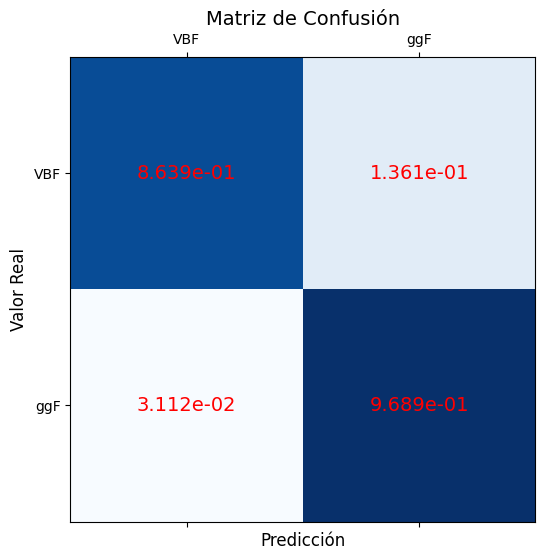

In [51]:
plot_matriz(matriz, porcentaje = False, normalizado=True)

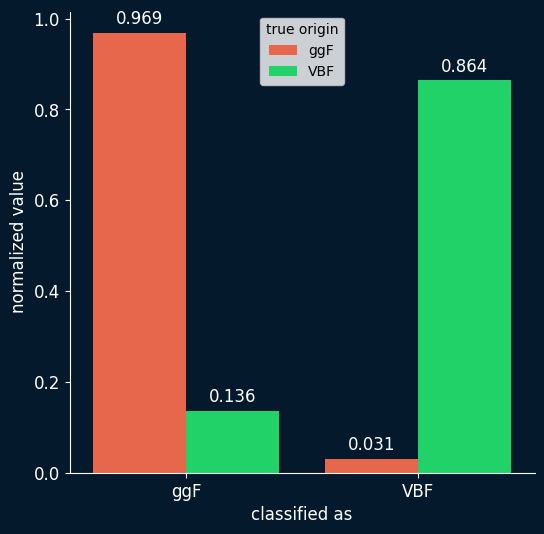

In [52]:
plot_confusion_barras(matriz)

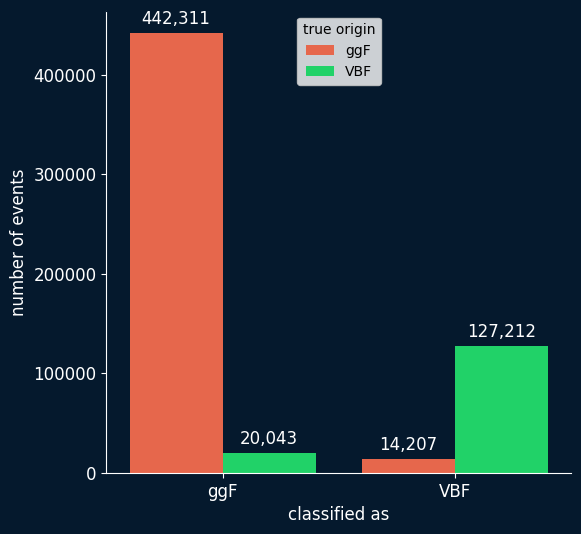

In [53]:
plot_confusion_barras(matriz, normalizado=False)

In [ ]:
# Encontrar mejor modelo
# best_model = find_best_model(X_train, y_train, X_test, y_test, X_val, y_val)

In [ ]:
from sklearn.metrics import f1_score
y_pred = modelo.predict(X_test)
f1_score(y_test, y_pred>0.5)

0.881354053361231

In [ ]:
modelo

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['logloss', 'auc'],
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, objective='binary:logistic', ...)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Supongamos que 'X' es tu conjunto de datos original
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_X.sample(100, random_state=1))
# X_tsne = tsne.fit_transform(df_X)

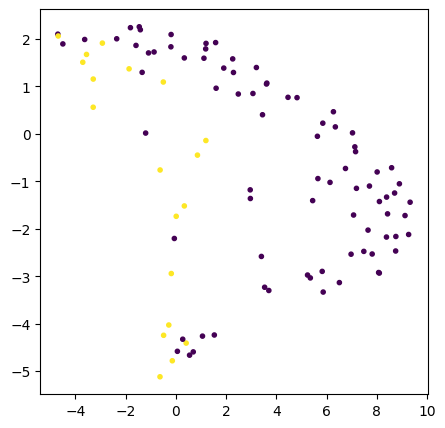

In [ ]:
plt.figure(figsize=[5, 5])
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_y.sample(100, random_state=1).to_numpy(), cmap='viridis', marker='.')
# plt.plot(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Escalar los datos
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_X)
# Aplicar PCA para reducir a 2 dimensiones (o el número de dimensiones deseado)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

x_pca

array([[ 2.231308  , -0.03110132],
       [ 3.343872  , -2.1386342 ],
       [ 2.1608586 , -1.622821  ],
       ...,
       [ 0.9992133 ,  2.1080778 ],
       [-0.04940485,  1.0574229 ],
       [-0.9558845 , -0.44297534]], dtype=float32)

In [ ]:
df_y.to_numpy()

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
import seaborn as sns 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import register_cmap

# relative positions of colors in cmap/palette 
pos = [0.0,1.0]
ggF = "#FF5733" # rojo
VBF = "#03ef62" # verde
colors=[ggF,VBF]

cmap = LinearSegmentedColormap.from_list("", list(zip(pos, colors)))
# register_cmap("cmap_presentacion", cmap)

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: color, Length: 100000, dtype: int64


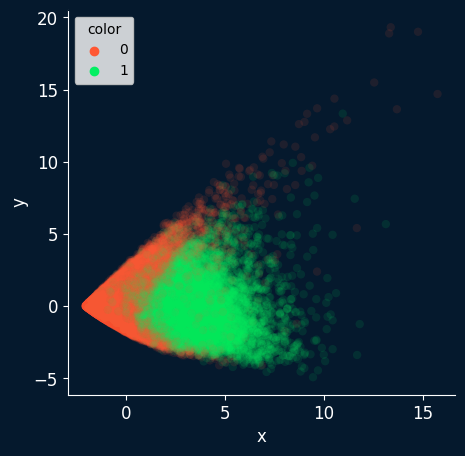

In [ ]:
# from matplotlib.colors import listedcolormap
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap



# from sklearn.manifold import TSNE

def graficar(modelo , df_X, df_y):
    
    
    # # Escalar los datos
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(df_X)
    
    # Aplicar PCA para reducir a 2 dimensiones mis datos originales
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(x_scaled)
    
    # hago el dataframe para el gráfico con seaborn
    df_plot = pd.DataFrame()
    df_plot["x"] = x_pca[:, 0]
    df_plot["y"] = x_pca[:, 1]
    df_plot["color"] = df_y.to_numpy()
    print(df_plot["color"])
    
    
    # voy a usar esta para que vaya entre los colores que yo quiera

    custom_palette = sns.color_palette([ggF, VBF])
    cmap_custom = LinearSegmentedColormap.from_list('custom_palette', [ggF, VBF])
    
    ##### NO USADO ####
    # # grafico los colores creando nuevos puntos
    # x1_line = np.linspace(x_pca[:, 0].min(), x_pca[:, 0].max(), 300)
    # x2_line = np.linspace(x_pca[:, 1].min(), x_pca[:, 1].max(), 300)
    # X, Y = np.meshgrid(x1_line, x2_line)
    # x_new = np.column_stack((X.ravel(), Y.ravel()))
    # x_new_7d = pca.inverse_transform(x_new) # para predecir el modelo tengo que pasar los puntos que cree de 2 a 7 dimensiones
    # y_pred = modelo.predict(x_new_7d).reshape(X.shape)
    # colores = ListedColormap(["y", "b"])
    # plt.contourf(X, Y, y_pred, cmap=colores)
    
    
    # Configurar el color del fondo y de las barras
    fondo_color = "#05192d"
    colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
    blanco = "#ffffff"
    
    # realizo el grafico
    plt.figure(figsize=[5, 5])
    
    ax = sns.scatterplot(data = df_plot, 
                         x="x", 
                         y="y", 
                         hue="color", 
                         palette=custom_palette, 
                        #  palette=sns.color_palette('cmap_presentacion', as_cmap = True), 
                         alpha=0.1,
                         linewidth=0)
    
    # ax = plt.scatter(df_plot["x"], df_plot["y"], cmap=cmap_custom, alpha=0.1)
    
    # color del fondo
    ax.set_facecolor(fondo_color)
    plt.gcf().set_facecolor(fondo_color)
    
    # Cambiar el color del borde del gráfico
    ax.spines['top'].set_edgecolor(fondo_color)
    ax.spines['right'].set_edgecolor(fondo_color)
    ax.spines['bottom'].set_edgecolor(blanco)
    ax.spines['left'].set_edgecolor(blanco)
        
    # Cambiar el color de las letras y números
    color_letras_numeros = "#ffffff"
    ax.tick_params(axis='both', colors=color_letras_numeros)
    ax.xaxis.label.set_color(color_letras_numeros)
    ax.yaxis.label.set_color(color_letras_numeros)
    ax.title.set_color(color_letras_numeros)
    
    # Ajustar el tamaño de los números en los ejes
    tamanio_numeros_ejes = 12
    ax.tick_params(axis='both', labelsize=tamanio_numeros_ejes)
    
    # Ajustar el tamaño de las etiquetas de los ejes y el título
    tamanio_etiquetas_ejes = 12
    ax.xaxis.label.set_size(tamanio_etiquetas_ejes)
    ax.yaxis.label.set_size(tamanio_etiquetas_ejes)
    ax.title.set_size(tamanio_etiquetas_ejes)
    
    plt.show()

graficar(modelo, 
         df_X.sample(100000, random_state=123), 
         df_y.sample(100000, random_state=123))
        #  pd.DataFrame(modelo.predict(df_X)).sample(100000, random_state=123))

In [ ]:
x_scaled

array([[ 1.2466314 ,  1.3013568 ,  0.12531842,  1.334695  ,  1.321277  ,
        -0.00987016],
       [ 2.7222798 ,  2.355728  , -0.32110608,  1.4937375 ,  0.04398152,
         1.1959598 ],
       [ 1.6298046 ,  1.8871096 ,  0.3327925 ,  0.3108919 , -0.48814747,
         1.1744171 ],
       ...,
       [ 0.01707646, -0.1967607 ,  0.7662449 , -0.23734948,  2.7475393 ,
        -0.30474076],
       [-0.38668123, -0.35826653,  0.40027875,  0.2560899 ,  0.74473405,
        -0.5362667 ],
       [-0.53439504, -0.04268138, -0.7511552 ,  0.13397986, -0.57631624,
        -0.610732  ]], dtype=float32)

In [ ]:
importancia = dict(zip(modelo.feature_names_in_, modelo.feature_importances_))
df_importancia = pd.DataFrame(modelo.feature_importances_, index=modelo.feature_names_in_, columns=["importances"])
importancias_ordenadas = df_importancia.sort_values(by=["importances"], ascending=False)
importancias_ordenadas

,importances
mjj,0.866930
jet1_e,0.060471
jet1_pt,0.041378
jet2_pt,0.014449
detajj,0.011364
jet2_e,0.005407


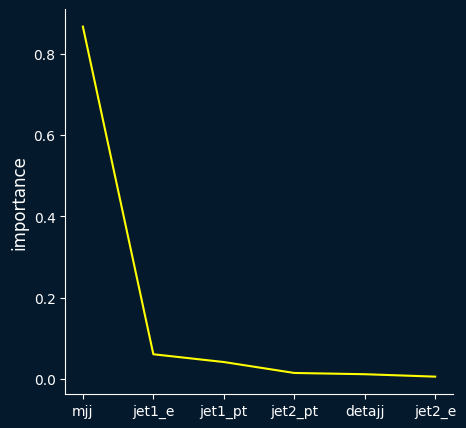

In [ ]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(importancias_ordenadas, color='yellow')
ax.set_ylabel("importance", color='white', fontsize=12)

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


plt.show()

# OVERTRAINING?

In [28]:
from sklearn.model_selection import learning_curve

# uso el mismo modelo que usé antes, pero sin entrenar, le entrego los mismos parámetros de entrenamiento
modelo_learning_curve = XGBClassifier(**params)

# Genera la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    modelo_learning_curve, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

In [29]:
print(train_sizes)
print(train_scores)
print(test_scores)
print(np.mean(train_scores, axis=1))

[ 112704  225408  338112  450816  563521  676225  788929  901633 1014337
 1127042]
[[0.94773921 0.94794329 0.94794329 0.94794329 0.94794329]
 [0.94583156 0.94566741 0.94566741 0.94566741 0.94566741]
 [0.94534355 0.94521342 0.94510695 0.94510695 0.94510695]
 [0.94485333 0.94470693 0.944667   0.944667   0.944667  ]
 [0.94483968 0.94459124 0.94454155 0.94452913 0.94452913]
 [0.94451107 0.94435876 0.94441199 0.94437502 0.94437502]
 [0.94448296 0.94433466 0.94433339 0.94427889 0.94427889]
 [0.9443787  0.94435319 0.94430439 0.94431104 0.94422786]
 [0.94431042 0.94417634 0.94413395 0.94419705 0.94420493]
 [0.94428158 0.9442035  0.94417067 0.94413607 0.94422657]]
[[0.94222763 0.94299779 0.94304038 0.9427598  0.94320344]
 [0.94271386 0.94327107 0.94340239 0.9431431  0.94338089]
 [0.9429339  0.94320364 0.94348402 0.94327087 0.9433525 ]
 [0.94300489 0.94323203 0.94345917 0.94341638 0.94359739]
 [0.94300489 0.9431646  0.94340239 0.94329216 0.94347672]
 [0.94308297 0.94321428 0.94346272 0.94342348 

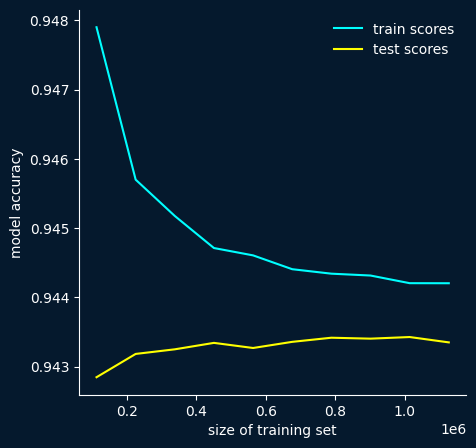

In [47]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(train_sizes, np.mean(train_scores, axis=1), label="train scores", color = "#00FFFF")
ax.plot(train_sizes, np.mean(test_scores, axis=1), label="test scores", color = "yellow")
ax.set_xlabel("size of training set", color="white")
ax.set_ylabel("model accuracy", color="white")
# ax.legend(frameon=False)
# for text in legend.get_texts():
#     text.set_color('white')

legend = ax.legend(["train scores", "test scores"], frameon=False)
for text in legend.get_texts():
    text.set_color('white')


# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


plt.show()

In [31]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [32]:
# uso el mismo modelo que usé antes, pero sin entrenar, le entrego los mismos parámetros de entrenamiento
modelo_validacion_cruzada = XGBClassifier(**params)

# Realiza validación cruzada
cv_scores = cross_val_score(modelo_validacion_cruzada, X_train, y_train, cv=5, scoring='f1')

cv_scores

array([0.88069343, 0.88125871, 0.88197393, 0.88149673, 0.88191233])

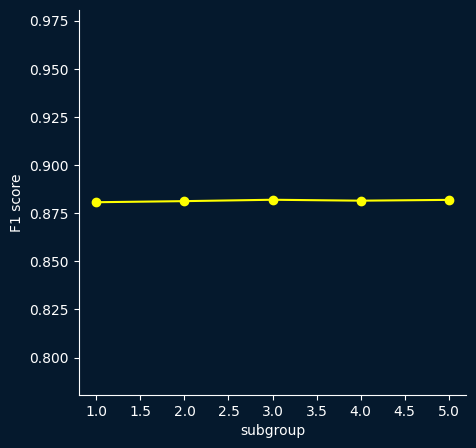

In [36]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(range(1,6),cv_scores, color = "yellow")
ax.scatter(range(1,6),cv_scores, color = "yellow")
ax.set_xlabel("subgroup", color = "white")
ax.set_ylabel("F1 score", color = "white")
ax.set_ylim([cv_scores[0]-0.1, cv_scores[0]+0.1])

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


plt.show()

[1 0 0 ... 0 0 0]
[0.9588594  0.00120824 0.48558706 ... 0.00213837 0.02181902 0.0018938 ]
[ 0.04114062 -0.00120824 -0.48558706 ... -0.00213837 -0.02181902
 -0.0018938 ]


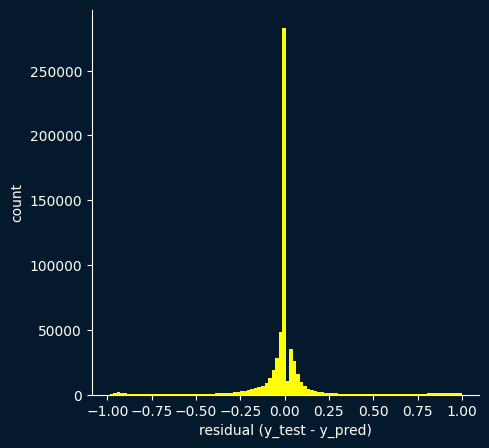

In [34]:
# residuos
y_test_numpy = y_test.to_numpy().T[0]
y_pred = modelo.predict(X_test)
print(y_test_numpy)
print(y_pred)
residuos = y_test_numpy - y_pred
# residuos = residuos.sample(100)
print(residuos)
fig, ax = plt.subplots(figsize=[5, 5])
ax.hist(residuos, bins=100, color="yellow")
ax.set_xlabel("residual (y_test - y_pred)", color="white")
ax.set_ylabel("count", color="white")

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


plt.show()